# Build a Predictive Time Series Model for Larcenies

import python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

set figure size

In [43]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Section 0: Load the data and clean

read the raw data set from CSV file

In [44]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [45]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


In [46]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [47]:
df.index = df['incident_dt']

# Section 1: Larceny theft over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [48]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [49]:
larceny_incidents['incident_dt'].count()

27657

lets roll up the events up by month and study the pattern over time

In [50]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [51]:
larceny_monthly_counts.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

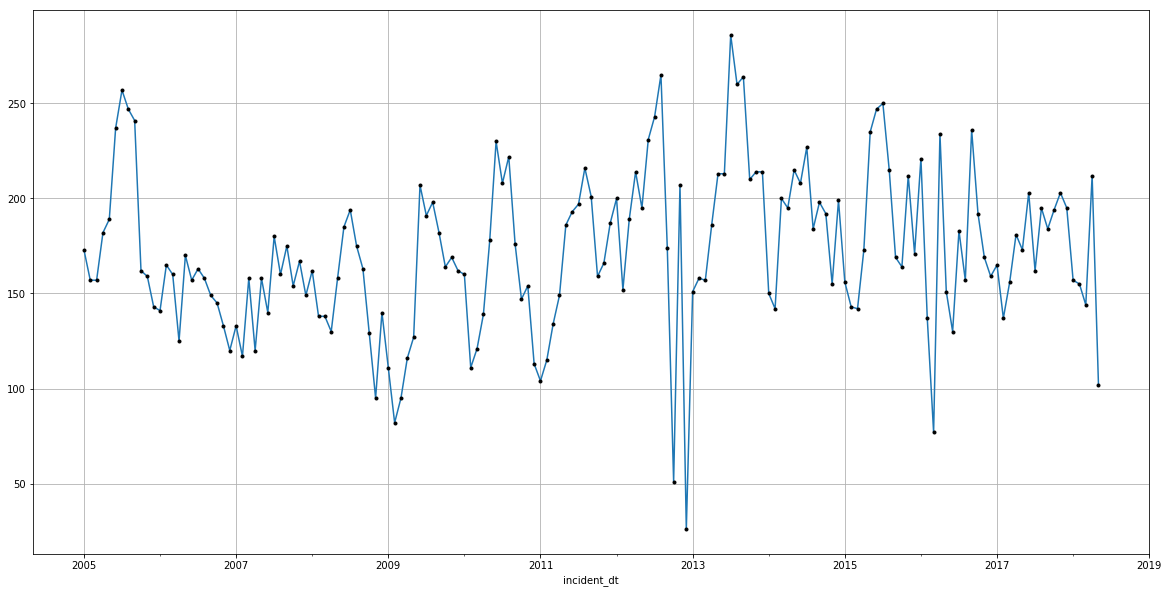

In [52]:
larceny_monthly_counts.plot()
larceny_monthly_counts.plot(style='k.', grid=True)

## Section 1.1 Modeling the data with a time series analysis

Grid search for best ARIMA model

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [23]:
start = datetime.datetime.now()
print(datetime.datetime.now() - start)

0:00:00.000285


In [39]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    run_start = datetime.datetime.now()
    print("starting run at {}".format(run_start))
    eval_cnt = 0
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model_start = datetime.datetime.now()
                    print("evaluating order {}".format(order))
                    mse = evaluate_arima_model(dataset, order)
                    eval_cnt += 1
                    model_run_time = datetime.datetime.now() - model_start
                    current_run_time = datetime.datetime.now() - run_start
                    print("evaluated model # {} model run time {} total run time {}".format(eval_cnt, 
                                                                                            model_run_time,
                                                                                           current_run_time))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print("new best model {} with score of {}".format(best_cfg, best_score))
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))
 

In [26]:
lar_series = larceny_monthly_counts

Specifically for your model, ARIMA(1, 0, 12) means that it you are describing some response variable (Y) by combining a 1st order Auto-Regressive model and a 12th order Moving Average model. A good way to think about it is (AR, I, MA). This makes your model look the following, in simple terms:

Y = (Auto-Regressive Parameters) + (Moving Average Parameters)

The 0 in the between the 1 and the 12 represents the 'I' part of the model (the Integrative part) and it signifies a model where you're taking the difference between response variable data - this can be done with non-stationary data and it doesn't seem like you're dealing with that, so you can just ignore it.



In [36]:
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0,13)
warnings.filterwarnings("ignore")

_for testing_

p_values = [12]
d_values = [1]
q_values = [12]

In [37]:
evaluate_models(lar_series.values, p_values, d_values, q_values)

starting run at 2018-06-06 09:48:38.344064
evaluating order (0, 0, 0)
evaluated model # 1 model run time 0:00:00.143799 total run time 0:00:00.144833
0:24:34.268462
ARIMA(0, 0, 0) MSE=1376.147
evaluating order (0, 0, 1)
evaluated model # 2 model run time 0:00:01.230867 total run time 0:00:01.377505
0:24:35.500371
ARIMA(0, 0, 1) MSE=1338.884
evaluating order (0, 0, 2)
evaluated model # 3 model run time 0:00:02.152764 total run time 0:00:03.530402
0:24:37.653268
ARIMA(0, 0, 2) MSE=1425.506
evaluating order (0, 0, 3)
evaluated model # 4 model run time 0:00:04.353819 total run time 0:00:07.884336
0:24:42.007203
ARIMA(0, 0, 3) MSE=1527.580
evaluating order (0, 0, 4)
evaluated model # 5 model run time 0:00:06.935909 total run time 0:00:14.820357
0:24:48.943224
ARIMA(0, 0, 4) MSE=1612.226
evaluating order (0, 0, 5)
evaluated model # 6 model run time 0:00:11.077363 total run time 0:00:25.897837
0:25:00.020712
ARIMA(0, 0, 5) MSE=1641.814
evaluating order (0, 0, 6)
evaluated model # 7 model run 

evaluated model # 37 model run time 0:00:03.344601 total run time 0:07:32.503383
0:32:06.626250
ARIMA(3, 0, 0) MSE=1482.779
evaluating order (3, 0, 1)
evaluated model # 38 model run time 0:00:05.907344 total run time 0:07:38.410845
0:32:12.533712
ARIMA(3, 0, 1) MSE=1515.999
evaluating order (3, 0, 2)
evaluating order (3, 0, 3)
evaluating order (3, 0, 4)
evaluating order (3, 0, 5)
evaluating order (3, 0, 6)
evaluating order (3, 0, 7)
evaluating order (3, 0, 8)
evaluating order (3, 0, 9)
evaluating order (3, 0, 10)
evaluating order (3, 0, 11)
evaluating order (3, 0, 12)
evaluating order (3, 1, 0)
evaluated model # 39 model run time 0:00:02.731520 total run time 0:08:16.168727
0:32:50.291595
ARIMA(3, 1, 0) MSE=1718.117
evaluating order (3, 1, 1)
evaluated model # 40 model run time 0:00:05.247466 total run time 0:08:21.416307
0:32:55.539176
ARIMA(3, 1, 1) MSE=1743.586
evaluating order (3, 1, 2)
evaluating order (3, 1, 3)
evaluated model # 41 model run time 0:00:15.420402 total run time 0:0

evaluated model # 62 model run time 0:00:18.992827 total run time 0:27:15.648847
0:51:49.771727
ARIMA(7, 0, 0) MSE=1518.160
evaluating order (7, 0, 1)
evaluated model # 63 model run time 0:00:43.485525 total run time 0:27:59.134524
0:52:33.257422
ARIMA(7, 0, 1) MSE=1480.204
evaluating order (7, 0, 2)
evaluating order (7, 0, 3)
evaluating order (7, 0, 4)
evaluating order (7, 0, 5)
evaluating order (7, 0, 6)
evaluating order (7, 0, 7)
evaluating order (7, 0, 8)
evaluating order (7, 0, 9)
evaluating order (7, 0, 10)
evaluating order (7, 0, 11)
evaluating order (7, 0, 12)
evaluating order (7, 1, 0)
evaluated model # 64 model run time 0:00:15.583450 total run time 0:29:06.244431
0:53:40.367312
ARIMA(7, 1, 0) MSE=1656.325
evaluating order (7, 1, 1)
evaluated model # 65 model run time 0:00:25.891914 total run time 0:29:32.136525
0:54:06.259412
ARIMA(7, 1, 1) MSE=1457.075
evaluating order (7, 1, 2)
evaluated model # 66 model run time 0:00:51.738371 total run time 0:30:23.875051
0:54:57.997921


evaluating order (10, 2, 2)
evaluating order (10, 2, 3)
evaluating order (10, 2, 4)
evaluating order (10, 2, 5)
evaluating order (10, 2, 6)
evaluating order (10, 2, 7)
evaluating order (10, 2, 8)
evaluating order (10, 2, 9)
evaluating order (10, 2, 10)
evaluating order (10, 2, 11)
evaluating order (10, 2, 12)
evaluating order (10, 3, 0)
evaluating order (10, 3, 1)
evaluating order (10, 3, 2)
evaluating order (10, 3, 3)
evaluating order (10, 3, 4)
evaluating order (10, 3, 5)
evaluating order (10, 3, 6)
evaluating order (10, 3, 7)
evaluating order (10, 3, 8)
evaluating order (10, 3, 9)
evaluating order (10, 3, 10)
evaluating order (10, 3, 11)
evaluating order (10, 3, 12)
evaluating order (11, 0, 0)
evaluated model # 88 model run time 0:02:59.658063 total run time 2:31:39.409455
2:56:13.533151
ARIMA(11, 0, 0) MSE=1612.879
evaluating order (11, 0, 1)
evaluated model # 89 model run time 0:03:35.871750 total run time 2:35:15.282189
2:59:49.405089
ARIMA(11, 0, 1) MSE=1596.966
evaluating order

In [53]:
X = lar_series.values
order = (13,1,1)
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()

model = ARIMA(history, order=order)
model_fit = model.fit(disp=0)
# yhat = model_fit.forecast()[0]

In [60]:
forecast = model_fit.predict(start=len(history), end=len(X))

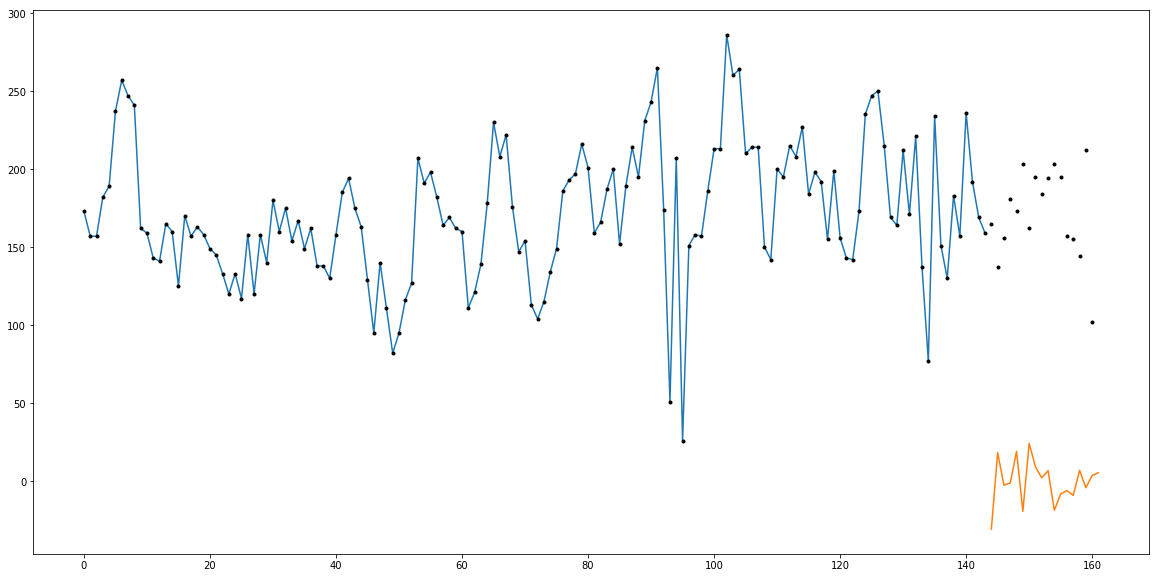

In [61]:
plt.plot(train)
plt.plot([None for i in train] + [x for x in forecast])
pd.Series(X).plot(style='k.')

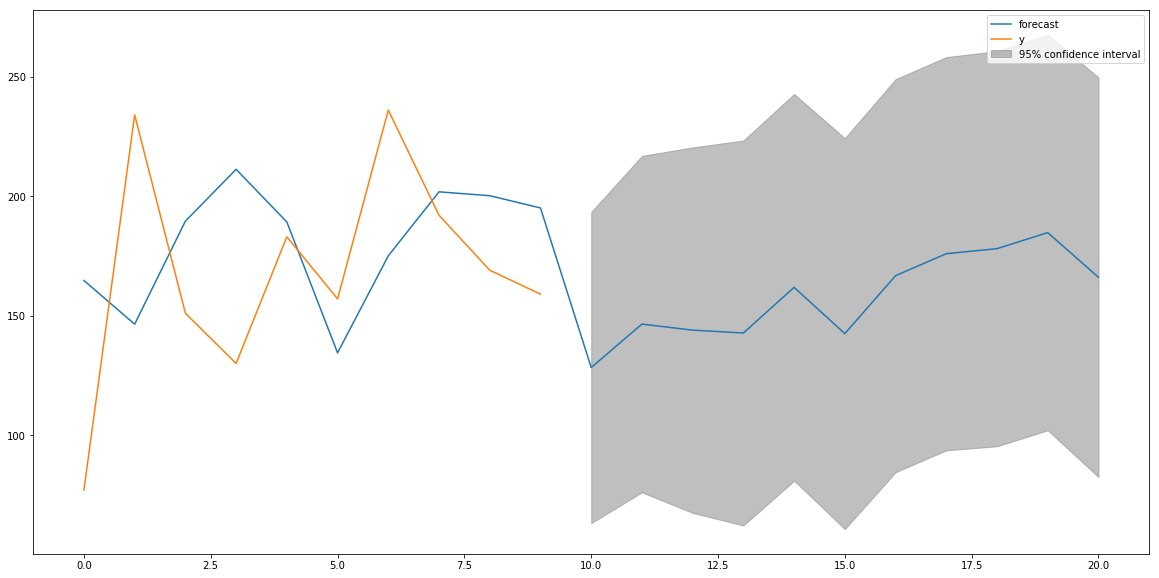

In [59]:
fig = model_fit.plot_predict(len(train)-10, len(train)+10)

In [ ]:
len()